# Overview for the grades of the abitur years from 2006 to 2022


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

RAW_PATH = os.path.join(sa.PROJECT_PATH, "data", "raw", "abi")

In [2]:
if os.path.exists(RAW_PATH):
    print("Raw data already exists, skipping download")
else:
    print("Downloading raw data")
    %run ../src/school_analysis/download_all.py --keep-raw

Raw data already exists, skipping download


## Load data


In [3]:
import re


def load_grades_per_year(path=RAW_PATH, pattern=r".*_grades.csv"):
    # Specific file name pattern
    file_name_pattern = re.compile(pattern)
    # Get a list of all files in the directory matching the pattern
    files = [file for file in os.listdir(
        path) if file_name_pattern.match(file)]
    grades_per_year = []

    # Load each file into a separate dataframe
    for file in files:
        file_path = os.path.join(path, file)
        dataframe_name = int(os.path.splitext(file)[0].split("_")[
                             0]) + 1  # The year of the exam
        df = pd.read_csv(file_path, index_col=1)
        df = df.drop(columns=['Unnamed: 0'])
        df["File"] = dataframe_name
        grades_per_year.append(df)

    multiindex_df = pd.concat(grades_per_year, keys=[
                              df['File'].iloc[0] for df in grades_per_year]).drop(columns="File")

    return multiindex_df


grades = load_grades_per_year()
fail = load_grades_per_year(pattern=r".*_grades_fail.csv")
grades
fail

BW            BY            BE  \
     Meta                                                                 
2015 - bestanden               48228.000000  41239.000000  14954.000000   
     - nicht bestanden (abs.)   1437.000000   1419.000000    713.000000   
     - nicht bestanden (%)         2.893386      3.326457      4.550967   
     Notenmittel                   2.455839      2.325018      2.423994   
2016 - bestanden               51101.000000  42032.000000  15876.000000   
...                                     ...           ...           ...   
2008 Notenmittel                   2.399712      2.426404      2.568393   
2009 - bestanden               43324.000000  33456.000000  13818.000000   
     - nicht bestanden (abs.)    863.000000    329.000000    891.000000   
     - nicht bestanden (%)         1.953063      0.973805      6.057516   
     Notenmittel                   2.397059      2.414021      2.542423   

                                         BB           HB           HH  \
     Meta                                                               
2015 - bestanden                6932.000000  3055.000000  8816.000000   
     - nicht bestanden (abs.)    319.000000   161.000000   343.000000   
     - nicht bestanden (%)         4.399393     5.006219     3.744950   
     Notenmittel                   2.308958     2.456334     2.431715   
2016 - bestanden                8062.000000  3235.000000  9451.000000   
...                                     ...          ...          ...   
2008 Notenmittel                   2.465812     2.468288     2.562962   
2009 - bestanden               11848.000000  2717.000000  5856.000000   
     - nicht bestanden (abs.)    519.000000    82.000000   160.000000   
     - nicht bestanden (%)         4.196652     2.929618     2.659574   
     Notenmittel                   2.418746     2.447037     2.528108   

                                         HE           MV            NI  \
     Meta                                                                
2015 - bestanden               29147.000000  3512.000000  32387.000000   
     - nicht bestanden (abs.)    864.000000   245.000000   1488.000000   
     - nicht bestanden (%)         2.878944     6.521161      4.392620   
     Notenmittel                   2.425176     2.367995      2.607750   
2016 - bestanden               25574.000000  4092.000000  33770.000000   
...                                     ...          ...           ...   
2008 Notenmittel                   2.470603     2.398308      2.710509   
2009 - bestanden               21286.000000  4313.000000  25458.000000   
     - nicht bestanden (abs.)    603.000000   146.000000    896.000000   
     - nicht bestanden (%)         2.754808     3.274277      3.399863   
     Notenmittel                   2.455689     2.370114      2.690797   

                                         NW            RP           SL  \
     Meta                                                                
2015 - bestanden               85398.000000  16272.000000  3565.000000   
     - nicht bestanden (abs.)   2429.000000    375.000000    94.000000   
     - nicht bestanden (%)         2.765664      2.252658     2.569008   
     Notenmittel                   2.498030      2.538188     2.436466   
2016 - bestanden               86347.000000  16969.000000  3875.000000   
...                                     ...           ...          ...   
2008 Notenmittel                   2.637675      2.626894     2.510605   
2009 - bestanden               69020.000000  14650.000000  3029.000000   
     - nicht bestanden (abs.)   1771.000000    206.000000    90.000000   
     - nicht bestanden (%)         2.501730      1.386645     2.885540   
     Notenmittel                   2.631601      2.623775     2.495081   

                                          N           ST            SH  \
     Meta                                                                
2015 - bestanden                8706.0000

In [4]:
grades_flat = grades.unstack(0)
fail_flat = fail.unstack(0)
fail_flat
# grades_flat

BW                              \
                                  2015          2016          2017   
Meta                                                                 
- bestanden               48228.000000  51101.000000  51197.000000   
- nicht bestanden (abs.)   1437.000000   1299.000000   1395.000000   
- nicht bestanden (%)         2.893386      2.479008      2.652495   
Notenmittel                   2.455839      2.436089      2.430781   

                                                                    \
                                  2018          2019          2020   
Meta                                                                 
- bestanden               50150.000000  49339.000000  47436.000000   
- nicht bestanden (abs.)   1574.000000   1813.000000   1501.000000   
- nicht bestanden (%)         3.043075      3.544338      3.067209   
Notenmittel                   2.423057      2.435941      2.408555   

                                                                    \
                                  2021          2022          2010   
Meta                                                                 
- bestanden               44975.000000  42464.000000  45080.000000   
- nicht bestanden (abs.)    928.000000   1043.000000    618.000000   
- nicht bestanden (%)         2.021654      2.397315      1.352357   
Notenmittel                   2.376714      2.232425      2.386205   

                                        ...           TH               \
                                  2011  ...         2021         2022   
Meta                                    ...                             
- bestanden               46277.000000  ...  6534.000000  6279.000000   
- nicht bestanden (abs.)   1358.000000  ...   106.000000   110.000000   
- nicht bestanden (%)         2.850845  ...     1.596386     1.721709   
Notenmittel                   2.436431  ...     2.158540     2.055614   

                                                                              \
                                 2010         2011         2012         2013   
Meta                                                                           
- bestanden               8626.000000  6536.000000  5030.000000  5128.000000   
- nicht bestanden (abs.)   158.000000   112.000000    72.000000   108.000000   
- nicht bestanden (%)        1.798725     1.684717     1.411211     2.062643   
Notenmittel                  2.303988     2.300994     2.203439     2.187285   

                                                                              
                                 2014         2007         2008         2009  
Meta                                                                          
- bestanden               5136.000000  9993.000000  9533.000000  9753.000000  
- nicht bestanden (abs.)   126.000000   199.000000   237.000000   176.000000  
- nicht bestanden (%)        2.394527     1.952512     2.425793     1.772585  
Notenmittel                  2.167660     2.327019     2.331826     2.321839  

[4 rows x 256 columns]

## Plot the data


In [5]:
def get_average_grades_by_year_and_state(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        # if state == "BW":
        #     continue
        state_data = flat_data[state].copy()
        average_grades_per_year = state_data.apply(lambda col: np.dot(
            col, state_data.index) / col.sum(), axis=0).sort_index()
        plot_data[state] = average_grades_per_year
    return plot_data.copy()

In [6]:
def get_percentage_failed(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        state_data = flat_data[state].copy()
        plot_data[state] = state_data.loc["- nicht bestanden (%)"]
    return plot_data.sort_index().copy()

In [7]:

def get_number_of_final_kids(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        state_data = flat_data[state].copy()
        base = flat_data[state, flat_data[state].columns.sort_values()[0]]
        base_sum = (base["- bestanden"] + base["- nicht bestanden (abs.)"])
        plot_data[state] = (state_data.loc["- bestanden"] +
                            state_data.loc["- nicht bestanden (abs.)"] - base_sum) / base_sum
    return plot_data.sort_index().copy()

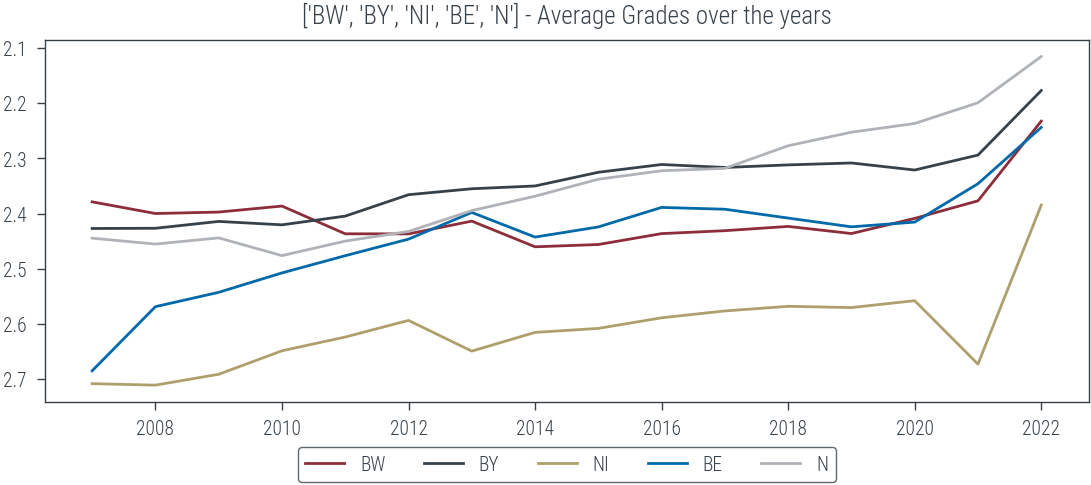

In [8]:
STATES = ["BW", "BY", "NI", "BE", "N"]


fig, axs = plt.subplots(1, 1)
axs.set_title(f"{STATES} - Average Grades over the years")
data = get_average_grades_by_year_and_state(grades_flat, STATES)
axs.plot(data)
axs.invert_yaxis()
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=len(data.columns), labels=data.columns)
plt.show()

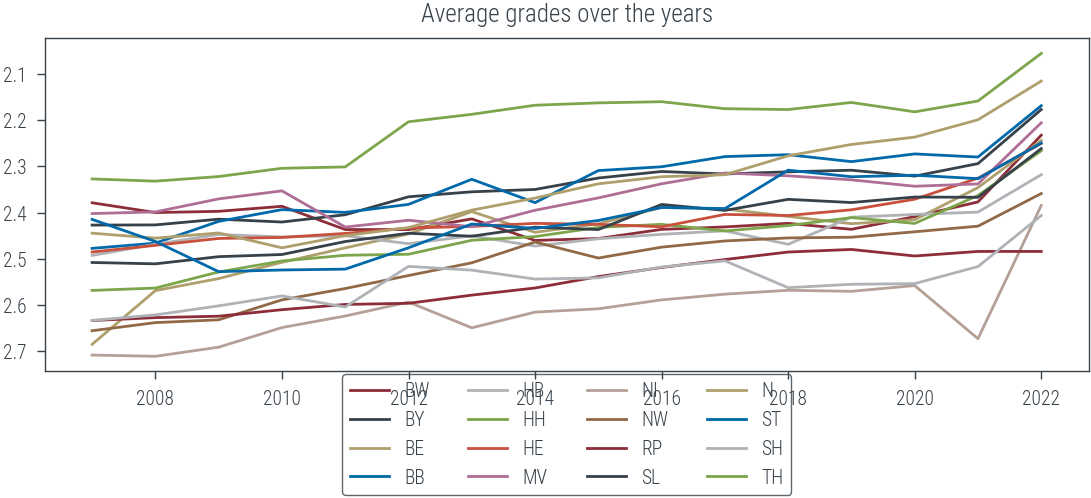

,BW,BY,BE,BB,HB,HH,HE,MV,NI,NW,RP,SL,N,ST,SH,TH
2007,2.378554,2.426831,2.684535,2.477192,2.492400,2.568063,2.485061,2.401858,2.707842,2.655228,2.633172,2.507656,2.444318,2.414495,2.632861,2.327019
2008,2.399712,2.426404,2.568393,2.465812,2.468288,2.562962,2.470603,2.398308,2.710509,2.637675,2.626894,2.510605,2.455041,2.462244,2.620997,2.331826
2009,2.397059,2.414021,2.542423,2.418746,2.447037,2.528108,2.455689,2.370114,2.690797,2.631601,2.623775,2.495081,2.443819,2.527483,2.601435,2.321839
2010,2.386205,2.420180,2.507252,2.393404,2.452323,2.504435,2.453569,2.352834,2.648322,2.588494,2.609739,2.490420,2.475950,2.523886,2.579945,2.303988
2011,2.436431,2.404410,2.476110,2.399324,2.449828,2.492052,2.444773,2.430998,2.623373,2.563940,2.598358,2.462353,2.449638,2.522021,2.603881,2.300994
2012,2.436582,2.365637,2.446057,2.382042,2.467026,2.489867,2.433217,2.416351,2.593283,2.535859,2.595903,2.444478,2.432191,2.475888,2.516069,2.203439
2013,2.413463,2.354857,2.397751,2.327765,2.450058,2.459626,2.429670,2.430346,2.648889,2.508382,2.578257,2.450858,2.394449,2.424502,2.524187,2.187285
2014,2.459965,2.349801,2.442383,2.378277,2.472257,2.451711,2.423100,2.394737,2.614983,2.463414,2.562806,2.431288,2.368356,2.434043,2.543489,2.167660
2015,2.455839,2.325018,2.423994,2.308958,2.456334,2.431715,2.425176,2.367995,2.607750,2.498030,2.538188,2.436466,2.337583,2.416800,2.540945,2.162576
2016,2.436089,2.310925,2.388650,2.300695,2.446801,2.425204,2.430461,2.337537,2.588537,2.474496,2.518416,2.382219,2.322252,2.388734,2.517497,2.160042


In [9]:

plot_data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
fig, axs = plt.subplots(1, 1)
ax = axs
ax.set_title('Average grades over the years')
ax.plot(plot_data)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(plot_data.columns)/4, labels=plot_data.columns)
# ax.set_ylim((2.1, 2.7))
ax.invert_yaxis()
plt.show()
plot_data

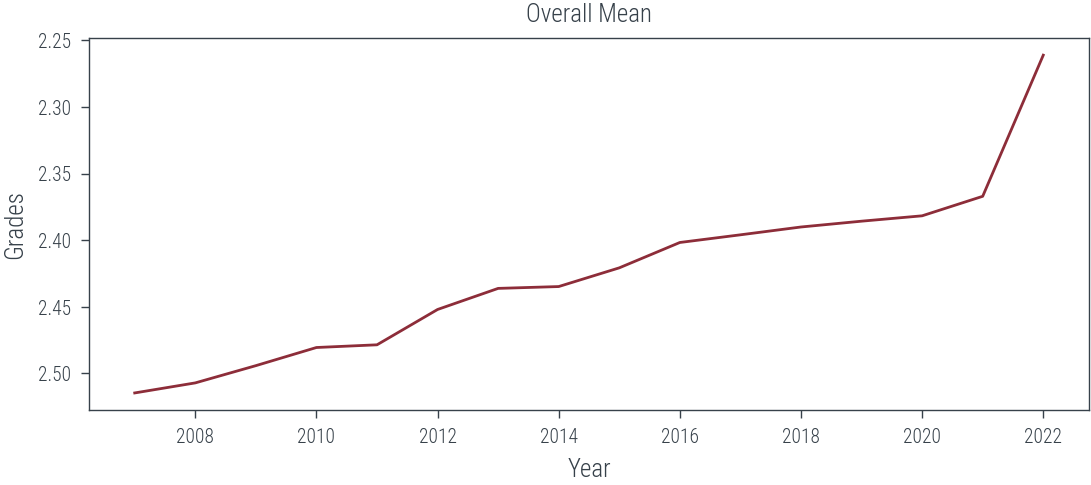

In [10]:
data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
overall_mean = data.mean(axis=1)
fig, axs = plt.subplots(1, 1)

ax = axs
ax.set_title("Overall Mean")
ax.plot(overall_mean)
ax.set_xlabel("Year")
ax.set_ylabel("Grades")
ax.invert_yaxis()
plt.show()

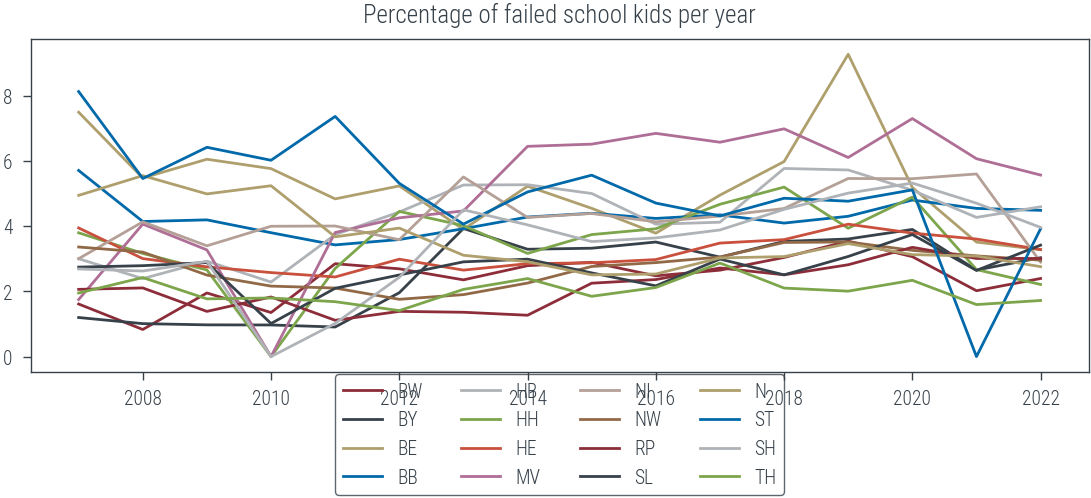

In [11]:
data = get_percentage_failed(fail_flat, fail_flat.columns.get_level_values(0))
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Percentage of failed school kids per year")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(data.columns)/4, labels=data.columns)
plt.show()

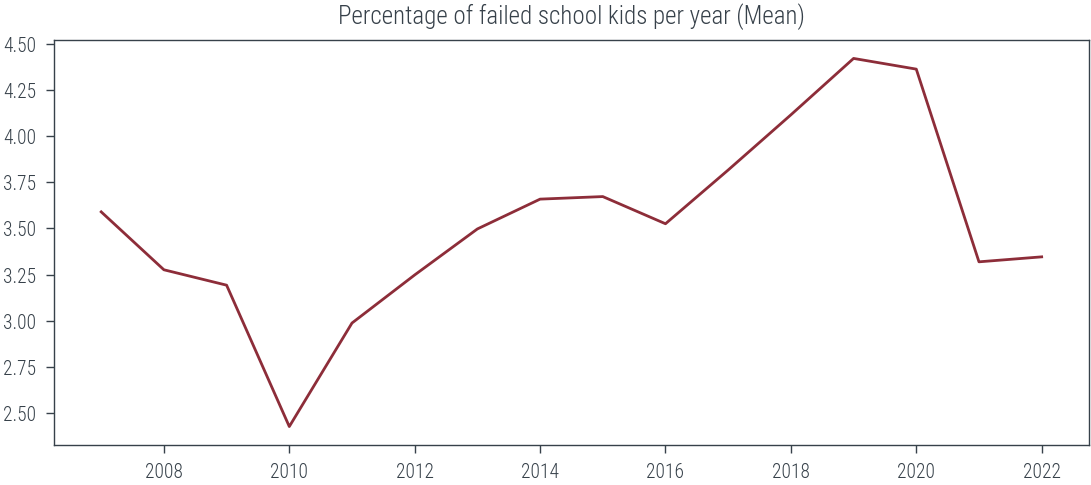

In [12]:
data = get_percentage_failed(fail_flat, fail_flat.columns.get_level_values(0))
data = data.mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Percentage of failed school kids per year (Mean)")
plt.show()

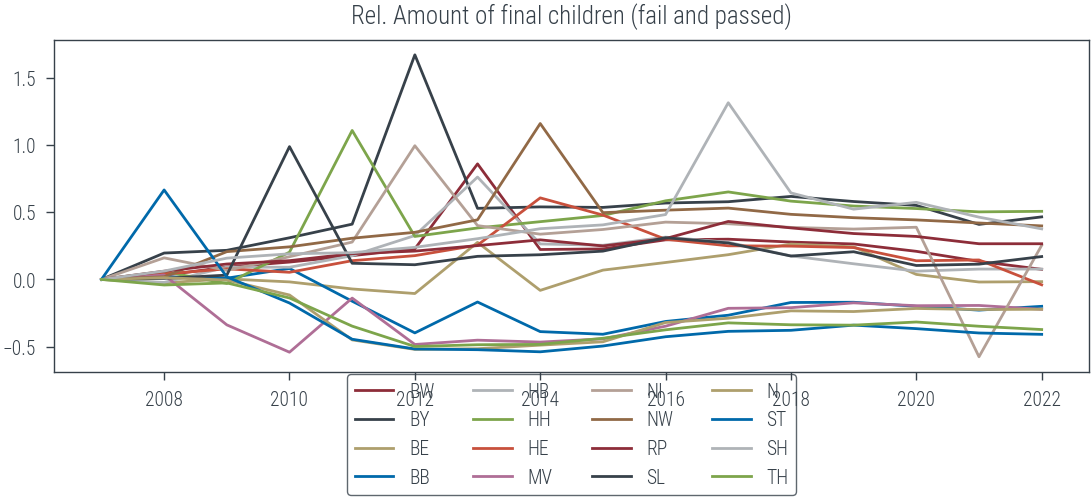

In [13]:
data = get_number_of_final_kids(
    fail_flat, fail_flat.columns.get_level_values(0))
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Rel. Amount of final children (fail and passed)")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(data.columns)/4, labels=data.columns)
plt.show()

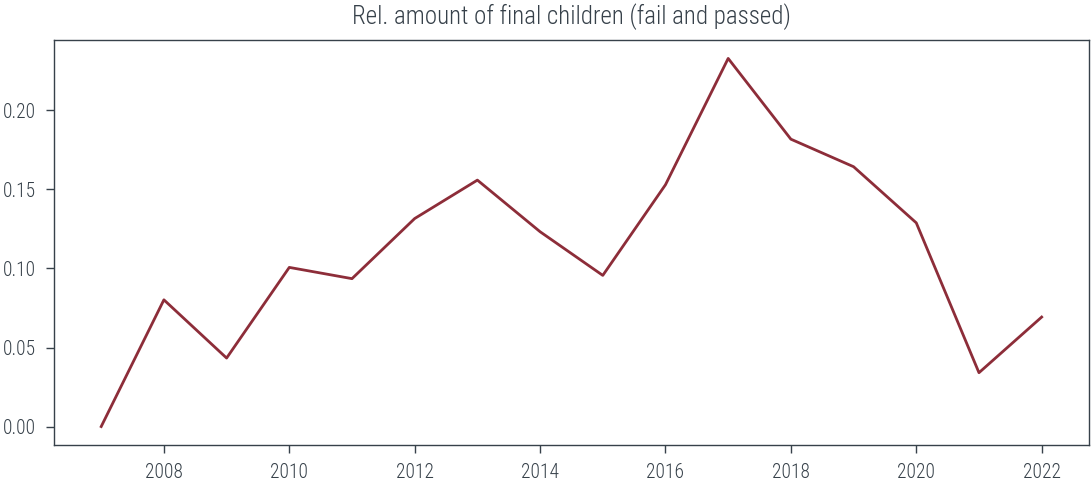

In [14]:
data = get_number_of_final_kids(
    fail_flat, fail_flat.columns.get_level_values(0))
data = data.mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Rel. amount of final children (fail and passed)")
plt.show()

## Deeper Analysis on the grades over the years


In [15]:
def group_by_grades(data: pd.DataFrame, group_by: float = 1.0) -> pd.DataFrame:
    data_c = data.copy()
    result = pd.DataFrame(columns=data_c.columns)

    # Check groups
    assert group_by > 0 and group_by <= 4.0, "Group_by > 0 and <= 4.0"

    # Create bounds
    bounds = [i/10 for i in range(10, 41, int(group_by*10))][1:]

    # Group
    for i, b in enumerate(bounds):
        lower_bound = 0.9 if i == 0 else bounds[i-1]
        upper_bound = b

        selected = data_c[(data_c.index <= upper_bound) &
                          (data_c.index > lower_bound)]
        result.loc[f"{lower_bound + 0.1 if i == 0 else bounds[i-1]} - {b}"] = selected.sum(
            axis=0)

    return result


group_half_grades = group_by_grades(grades_flat, 0.5)
group_half_grades

BW                                                        \
              2015     2016     2017     2018     2019     2020     2021   
1.0 - 1.5   4301.0   4867.0   4994.0   5117.0   4959.0   5183.0   5642.0   
1.5 - 2.0   8610.0   9269.0   9481.0   9443.0   8926.0   8872.0   8608.0   
2.0 - 2.5  12767.0  13638.0  13585.0  12912.0  12704.0  12282.0  11504.0   
2.5 - 3.0  13210.0  13973.0  13613.0  13557.0  13382.0  12607.0  11480.0   
3.0 - 3.5   8634.0   8657.0   8759.0   8461.0   8701.0   7855.0   7131.0   
3.5 - 4.0    706.0    697.0    765.0    660.0    667.0    637.0    610.0   

                                      ...      TH                          \
              2022     2010     2011  ...    2021    2022    2010    2011   
1.0 - 1.5   7619.0   5110.0   4322.0  ...  1232.0  1502.0  1124.0   917.0   
1.5 - 2.0   9501.0   8637.0   8473.0  ...  1624.0  1671.0  1925.0  1423.0   
2.0 - 2.5  10762.0  12017.0  12379.0  ...  1796.0  1633.0  2331.0  1737.0   
2.5 - 3.0   9304.0  11874.0  12679.0  ...  1354.0  1131.0  2150.0  1563.0   
3.0 - 3.5   4938.0   6848.0   7812.0  ...   515.0   334.0  1038.0   852.0   
3.5 - 4.0    340.0    594.0    612.0  ...    13.0     8.0    58.0    44.0   

                                                           
             2012    2013    2014    2007    2008    2009  
1.0 - 1.5   846.0   906.0   937.0  1206.0  1168.0  1240.0  
1.5 - 2.0  1236.0  1308.0  1278.0  2192.0  2016.0  2152.0  
2.0 - 2.5  1376.0  1361.0  1423.0  2731.0  2621.0  2582.0  
2.5 - 3.0  1104.0  1058.0  1089.0  2526.0  2435.0  2428.0  
3.0 - 3.5   454.0   483.0   400.0  1254.0  1221.0  1269.0  
3.5 - 4.0    14.0    12.0     9.0    84.0    72.0    82.0  

[6 rows x 256 columns]

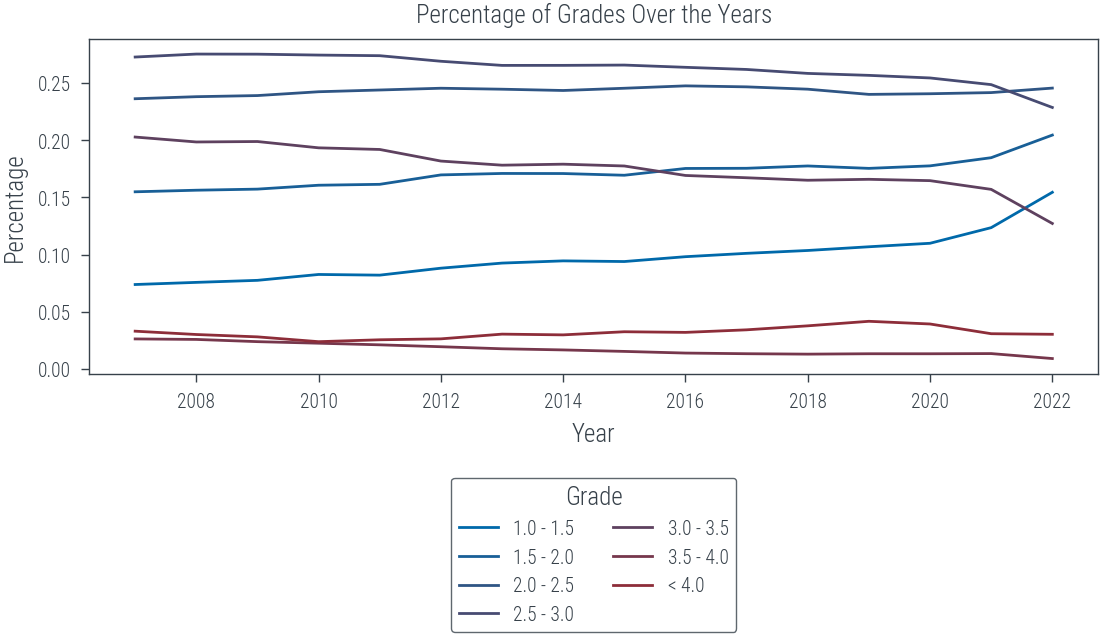

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Settings
STATES = grades_flat.columns.get_level_values(0)
# STATES = ["BW"]
GROUP = 0.5

# Group grades and add failed people
grouped = group_by_grades(grades_flat, GROUP)
grouped.loc["< 4.0"] = fail_flat.loc["- nicht bestanden (abs.)"]

# Get the percentage with grade


def get_percentage_with_grade(data: pd.DataFrame, states: list) -> pd.DataFrame:
    plot_data = pd.DataFrame()
    data_c = data.copy()
    for i, state in enumerate(states):
        if i != 0:
            plot_data += data_c[state]
        else:
            plot_data = data_c[state].copy()
    plot_data = plot_data.apply(lambda col: col / col.sum()).sort_index(axis=1)
    return plot_data.copy()


# Produce the right format
plot_data = get_percentage_with_grade(grouped, STATES).reset_index()
plot_data = plot_data.rename(columns={'index': 'Grade_Range'})
plot_data = pd.melt(plot_data, id_vars='Grade_Range', var_name='Year',
                    value_name='Percentage', value_vars=plot_data.columns.to_list()[1:])

# Create a linear gradient of colors from tue_blue to tue_red
num_grades = len(plot_data["Grade_Range"].unique())
colors = [
    (
        rgb.tue_blue[0] + (rgb.tue_red[0] - rgb.tue_blue[0]
                           ) * (i / (num_grades - 1)),
        rgb.tue_blue[1] + (rgb.tue_red[1] - rgb.tue_blue[1]
                           ) * (i / (num_grades - 1)),
        rgb.tue_blue[2] + (rgb.tue_red[2] - rgb.tue_blue[2]
                           ) * (i / (num_grades - 1)),
    )
    for i in range(num_grades)
]

# Plotting magic
fig, axs = plt.subplots(1, 1)
ax = axs
for i, g_range in enumerate(plot_data['Grade_Range'].unique().tolist()):
    group_data = plot_data.loc[plot_data['Grade_Range'] == g_range]

    ax.plot(
        group_data["Year"],
        group_data["Percentage"],
        color=colors[i],
    )
ax.set_title('Percentage of Grades Over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
g_ranges = plot_data['Grade_Range'].unique().tolist()
ax.legend(title='Grade', loc='lower center', bbox_to_anchor=(
    0.5, -0.8), ncol=len(g_ranges) // 3, labels=g_ranges)
plt.show()

## Linear Regression on the grades

This section aims to display the difference between the regression of previous trends to the changes in the grades after covid.


In [17]:
all_states = grades_flat.columns.get_level_values(0).unique()

# Create melted df (better for computation)
melted_data = grades_flat.copy().reset_index()
melted_data = melted_data.rename(columns={'Grade': 'grade'})
melted_data.loc[len(melted_data)] = fail_flat.loc["- nicht bestanden (abs.)"]
melted_data[melted_data['grade'].isna()] = 5.0
melted_data = pd.melt(melted_data, id_vars='grade', var_name=[
                      'state', 'year'], value_name='amount')
melted_data["year"] = melted_data['year'].astype(np.int32)
melted_data

,grade,state,year,amount
0,1.0,BW,2015,619.0
1,1.1,BW,2015,391.0
2,1.2,BW,2015,547.0
3,1.3,BW,2015,709.0
4,1.4,BW,2015,912.0
...,...,...,...,...
8187,3.7,TH,2009,15.0
8188,3.8,TH,2009,1.0
8189,3.9,TH,2009,0.0
8190,4.0,TH,2009,0.0


Regression on average grade for complete germany


w=[ 2.59222074e+01 -1.16624674e-02]; res=[0.00042497]


Text(0.5, 1.0, 'Linear Regression on the data before Covid')

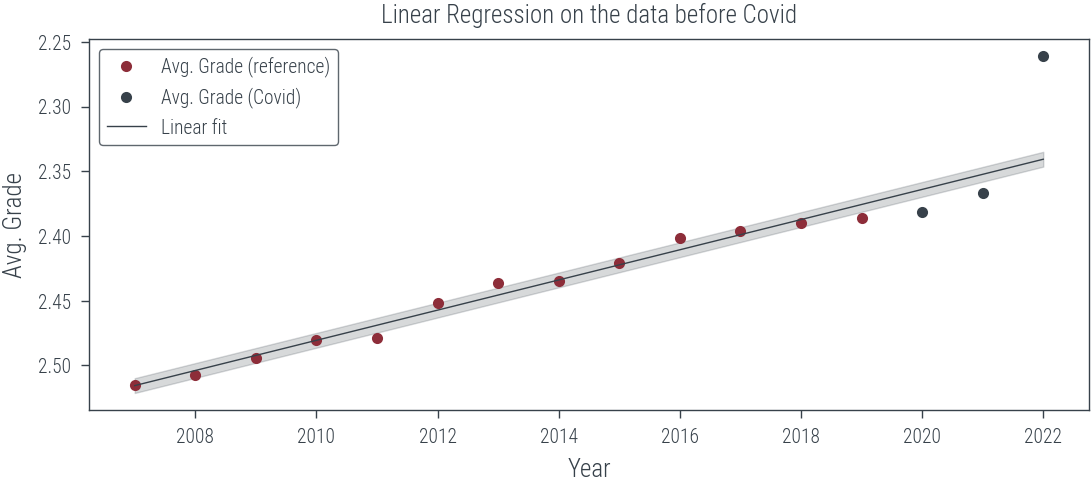

In [18]:
REFERENCE_BEFORE = 2020

data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
overall_mean = data.mean(axis=1)
overall_mean = overall_mean.reset_index().rename(
    columns={'index': 'year', 0: 'grade'})

reg_data = overall_mean.copy()
reg_data = reg_data.drop(
    reg_data[reg_data["year"].astype(np.int32) >= REFERENCE_BEFORE].index)
X = np.array([[1, reg_data["year"].iloc[i]] for i in range(reg_data.shape[0])])
y = np.array(reg_data["grade"])

w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f"w={w}; res={res}")

fig, ax = plt.subplots()

ax.plot(
    reg_data["year"],
    reg_data["grade"],
    ".",
    label="Avg. Grade (reference)",
    lw=0.5,
)

ax.plot(
    overall_mean.loc[overall_mean["year"] >= REFERENCE_BEFORE, "year"],
    overall_mean.loc[overall_mean["year"] >= REFERENCE_BEFORE, "grade"],
    ".",
    label="Avg. Grade (Covid)",
    lw=0.5,
)

xp = overall_mean["year"].unique().astype(np.int32)
ax.plot(
    xp, w[0] + w[1] * (xp), label="Linear fit", color=rgb.tue_dark, lw=0.5
)
ax.invert_yaxis()


ax.fill_between(
    xp,
    w[0] + w[1] * (xp) - np.sqrt(res / len(y)),
    w[0] + w[1] * (xp) + np.sqrt(res / len(y)),
    alpha=0.2,
    color=rgb.tue_dark,
)

ax.set_xlabel("Year")
ax.set_ylabel("Avg. Grade")
ax.legend()
ax.set_title("Linear Regression on the data before Covid")

Creates a regression for every state, grade based on all years before covid.


In [19]:
melted_data

,grade,state,year,amount
0,1.0,BW,2015,619.0
1,1.1,BW,2015,391.0
2,1.2,BW,2015,547.0
3,1.3,BW,2015,709.0
4,1.4,BW,2015,912.0
...,...,...,...,...
8187,3.7,TH,2009,15.0
8188,3.8,TH,2009,1.0
8189,3.9,TH,2009,0.0
8190,4.0,TH,2009,0.0


In [20]:
melted_data.loc[melted_data["state"] == "BW"].loc[melted_data["year"]
                                                  == 2022].loc[melted_data["grade"] == 1.0]
melted_data.loc[melted_data["year"] == 2022]

,grade,state,year,amount
224,1.0,BW,2022,1588.0
225,1.1,BW,2022,832.0
226,1.2,BW,2022,1067.0
227,1.3,BW,2022,1225.0
228,1.4,BW,2022,1352.0
...,...,...,...,...
7931,3.7,TH,2022,2.0
7932,3.8,TH,2022,0.0
7933,3.9,TH,2022,0.0
7934,4.0,TH,2022,0.0


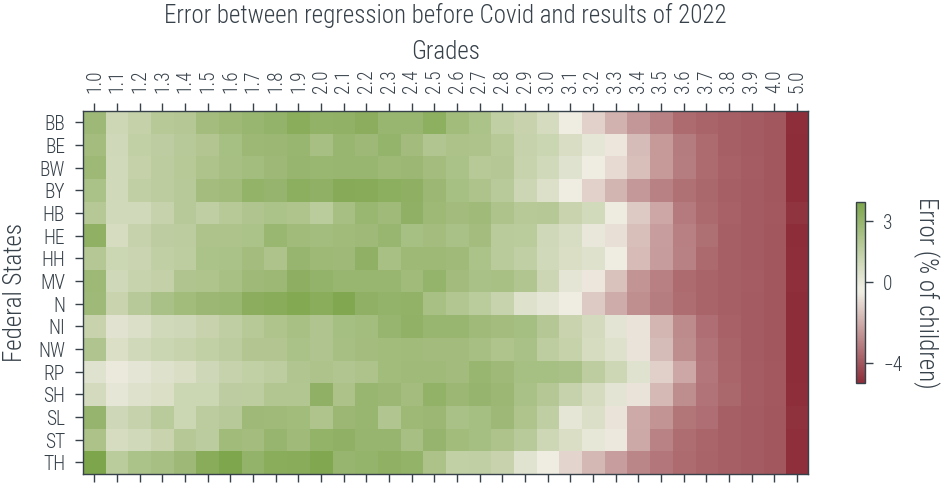

In [21]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'melted_data' is your DataFrame
REFERENCE_BEFORE = 2020

reg_data_before = melted_data.copy()
reg_data_before['percentage'] = reg_data_before.groupby(["year", "state"])['amount'].transform(
    lambda group: group / group.sum() * 100 if group.sum() > 0 else 0)
reg_data = reg_data_before.drop(
    reg_data_before[reg_data_before["year"].astype(np.int32) >= REFERENCE_BEFORE].index)

# Create an empty DataFrame to store regression results
results_df = pd.DataFrame(
    columns=["State", "Grade", "Intercept", "Slope", "Residual", "2022-Err"])

for s in reg_data.state.unique():
    state_data = reg_data.loc[reg_data.state == s]
    for g in state_data.grade.unique():
        grade_state_data = state_data.loc[state_data.grade == g]
        X = np.array([[1, grade_state_data["year"].iloc[i] - 2007]
                     for i in range(grade_state_data.shape[0])])
        y = np.array(grade_state_data["grade"])
        w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)

        # Calculate residuals for the year 2022
        residuals_2022 = reg_data_before.loc[reg_data_before["year"] == 2022].loc[reg_data_before["grade"]
                                                                                  == g].loc[reg_data_before["state"] == s, "percentage"].iloc[0] - (w[0] + w[1] * (2022 - 2007))

        # Append results by creating a new DataFrame and concatenating
        results_df.loc[len(results_df.index)] = [
            s, g, w[0], w[1], res[0], residuals_2022]

# Create a pivot table for the heatmap
pivot_table = results_df.pivot(
    index="State", columns="Grade", values="2022-Err")

# create a heatmap-like plot of the pivot table
fig, ax = plt.subplots()
colors = [(0, rgb.tue_red), (0.5, rgb.tue_lightgold),
          (0.53, rgb.tue_lightgold), (1, rgb.tue_green)]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
im = ax.matshow(pivot_table, cmap=custom_cmap)

# set the x-axis and y-axis labels
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index.to_list())
ax.set_ylabel("Federal States")

ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_xticklabels(pivot_table.columns.to_list(), rotation=90)
ax.set_xlabel("Grades", loc="center", )
ax.xaxis.set_label_position('top')

# set the colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5)
cbar.set_ticks([-4, 0, 3])
cbar.ax.set_ylabel("Error (% of children)", rotation=-90, va="bottom")

# set the plot title
ax.set_title("Error between regression before Covid and results of 2022")

# sns.heatmap(pivot_table, annot=True, fmt=".2f", linewidths=.5)
# plt.title('Regression Residuals Heatmap for 2022')
plt.show()